## Step 1: Import libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import pandas as pd
import random
import tensorflow as tf

from scipy import ndimage
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Dense, \
    GlobalAveragePooling3D, BatchNormalization, Dropout, \
        UpSampling3D, concatenate, Flatten, ConvLSTM2D, Bidirectional, \
            Cropping3D, ZeroPadding3D, Activation, Input, UpSampling3D, \
                Conv3DTranspose
from tensorflow.keras.models import Sequential, save_model, load_model, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


%matplotlib inline

2023-03-15 13:06:49.948344: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


## Step 2: Set Constants

In [2]:
SEED = 137
# using the range from segmentation
# [40:195,35:225,26:137]
# constants to crop images

MIN_WIDTH = 25 # 40
MAX_WIDTH = 215 # 195

MIN_HEIGHT = 35 # 35
MAX_HEIGHT = 225 # 225

MIN_DEPTH = 15 # 26
MAX_DEPTH = 143 # 137

In [3]:
#channel 
channel = 't1'

## Step 3: Load Data

In [4]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np

import pandas as pd

from google.cloud import storage

#need to change the '/home/yaoyx001/code/' to your folder location
parent_dir = "/home/svetlana.s.averina/code/avesveta/brain-tumor-project" 
#change to the channel that you need
channel = 'seg' 

directory = "raw_data" 

# Path
path = os.path.join(parent_dir, directory)
  
# Create the directory
if not os.path.exists(path):
    os.makedirs(path)
    print("Directory '% s' created" % directory)

#check the connection to GCP
client = storage.Client()

#get the Bucket Name from .env
bucket_name = 'row_data_bucket'
bucket = client.get_bucket(bucket_name)

blob_name=f"Grade_ID_{channel}_nii.pkl"
#get the blob(file)
blob = bucket.blob(blob_name)

cache_file = os.path.join(path, blob_name)
#save the file in cache_folder

if not os.path.isfile(cache_file):
    blob.download_to_filename(cache_file)

In [5]:
# load data
df = pd.read_pickle(f"../../raw_data/Grade_ID_{channel}_nii.pkl")

# the target columns have to be updated, it's only the fremework
df['Grade'] = df['Grade'].apply(lambda x: 1 if x == 'HGG' else 0)

In [6]:
df.info

<bound method DataFrame.info of      Grade BraTS_2020_subject_ID  \
0        0  BraTS20_Training_001   
1        0  BraTS20_Training_002   
2        0  BraTS20_Training_003   
3        0  BraTS20_Training_004   
4        0  BraTS20_Training_005   
..     ...                   ...   
364      0  BraTS20_Training_365   
365      0  BraTS20_Training_366   
366      0  BraTS20_Training_367   
367      0  BraTS20_Training_368   
368      0  BraTS20_Training_369   

                                                t1_nii  
0    [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...  
1    [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...  
2    [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...  
3    [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...  
4    [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...  
..                                                 ...  
364  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...  
365  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...  
366  [[[0.0, 0.0, 0.0,

In [6]:
#load surv data
life_exp_df = pd.read_csv('../../raw_data/survival_info_2020.csv')
life_exp_df.head(3)

,Brats20ID,Age,Survival_days,Extent_of_Resection
0,BraTS20_Training_001,60.463,289,GTR
1,BraTS20_Training_002,52.263,616,GTR
2,BraTS20_Training_003,54.301,464,GTR


In [7]:
#doing left merge on two df
life_exp_df = life_exp_df.merge(df, how='left', left_on='Brats20ID', right_on='BraTS_2020_subject_ID')

In [8]:
life_exp_df['Survival_days'][83] = '1767'

/tmp/ipykernel_34803/3266487694.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  life_exp_df['Survival_days'][83] = '1767'


In [9]:
life_exp_df['Survival_days'] = life_exp_df['Survival_days'].astype('int32')

In [10]:
life_exp_df.head(1)

,Brats20ID,Age,Survival_days,Extent_of_Resection,Grade,BraTS_2020_subject_ID,seg_nii
0,BraTS20_Training_001,60.463,289,GTR,1,BraTS20_Training_001,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."


In [11]:
#dropping the unused columns
life_exp_df = life_exp_df.drop(columns=['BraTS_2020_subject_ID','Grade','Extent_of_Resection'])

<Axes: xlabel='Survival_days', ylabel='Count'>

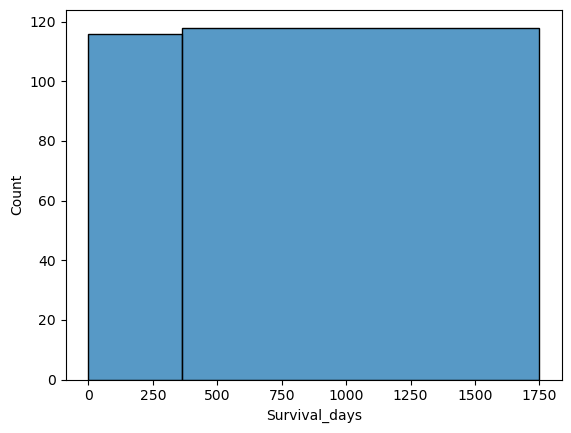

In [12]:
sns.histplot(life_exp_df['Survival_days'], bins=[0, 365, 1750])
#bins=[180, 365, 1750]

In [13]:
life_exp_df['Survival_days'].median()

371.0

In [14]:
life_exp_df['Survival_days'].std()

365.38075233375764

In [15]:
#target encoding for life expectancy

def survival_encoding(x):
    if x <= 365.00:
        return 0
    else:
        return 1

# the target columns have to be updated, it's only the fremework
life_exp_df['Survival_days'] = life_exp_df['Survival_days'].apply(survival_encoding)

## Step 4: EDA

In [16]:
print(f"Number of samples: {life_exp_df[f'{channel}_nii'].shape[0]}")
print(f"Short-term life expectancy examples: {life_exp_df[life_exp_df['Survival_days'] == 0].shape}")
print(f"Long-term life expectancy examples: {life_exp_df[life_exp_df['Survival_days'] == 1].shape}")


print("")
print("Single example Shape:")
print(f"Height: {life_exp_df[f'{channel}_nii'][0].shape[0]}")
print(f"Width: {life_exp_df[f'{channel}_nii'][0].shape[1]}")


Number of samples: 236
Short-term life expectancy examples: (116, 4)
Long-term life expectancy examples: (120, 4)

Single example Shape:
Height: 240
Width: 240


## Step 5: Crop Images and run Augmentation

In [17]:
# crop images
life_exp_df[f'{channel}_nii'] = life_exp_df[f'{channel}_nii'].apply(lambda x: np.array(x[MIN_HEIGHT:MAX_HEIGHT,MIN_WIDTH:MAX_WIDTH,MIN_DEPTH:MAX_DEPTH]))
X = life_exp_df[f'{channel}_nii']
y = life_exp_df['Survival_days']

In [18]:
del [life_exp_df]
import gc

gc.collect()

114

In [19]:
# reshape input data
X = np.array([np.array(val) for val in X])


In [20]:
#CHANGE IT IF WORK WITH seg
X[X>840]=840 # set the max value to 840

In [21]:
#CHANGE IT IF WORK WITH SEG
X = (X - 0)/840 # Min-Max Scaler

In [22]:
X = X.reshape(len(X), X[0].shape[0], X[0].shape[1], X[0].shape[2], 1)

In [23]:
# create train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=SEED)
# reset the index of y, so that the indexes of X and y match
y_train = y_train.reset_index(drop=True)

y_test = y_test.reset_index(drop=True)

In [24]:
del [X, y]
import gc

gc.collect()

0

In [25]:
# find indices of positive examples
pos_indices = np.where(y_train == 0)[0]

# perform data augmentation on positive examples
rotated_examples1 = np.rot90(X_train[pos_indices], axes=(1, 2))
rotated_examples2 = np.rot90(rotated_examples1, axes=(1, 2))

# append new images and labels to the training set
X_train = np.concatenate([X_train, rotated_examples1, rotated_examples2], axis=0)
y_train = np.concatenate([y_train, np.repeat(y_train[pos_indices], 2)], axis=0)

In [26]:
y_test[0]

0

In [27]:
# conduct augmentation on X_train for the life expectancy data
if not os.path.isfile(f"{channel}-X_train.npy"):
    
    np.save(f"{channel}-X_train.npy", X_train) #save the channel-X so we don't need always augument the X
    np.save(f"{channel}-y_train.npy", y_train)
    np.save(f"{channel}-X_test.npy", X_test) 
    np.save(f"{channel}-y_test.npy", y_test)
else:   #load the X direkly from npy file
    X_train = np.load(f"{channel}-X_train.npy",
                    mmap_mode='r')
    y_train = np.load(f"{channel}-y_train.npy",
                    mmap_mode='r')
    X_test = np.load(f"{channel}-X_test.npy",
                    mmap_mode='r')
    y_test = np.load(f"{channel}-y_test.npy",
                    mmap_mode='r')
    
    
    

In [28]:
X_train.shape

(372, 190, 190, 128, 1)

## Step 6: Define Model

In [29]:
##Sasha's but with sigmoid

in_layer = Input((190, 190, 128, 1))
bn = BatchNormalization()(in_layer)
cn1 = Conv3D(8, 
             kernel_size = (1, 5, 5), 
             padding = 'same',
             activation = 'relu')(bn)
bn2 = Activation('relu')(BatchNormalization()(cn1))

dn1 = MaxPooling3D((2, 2, 2))(bn2)
cn3 = Conv3D(16, 
             kernel_size = (3, 3, 3),
             padding = 'same',
             activation = 'relu')(dn1)
bn3 = Activation('relu')(BatchNormalization()(cn3))

dn2 = MaxPooling3D((1, 2, 2))(bn3)
cn4 = Conv3D(32, 
             kernel_size = (3, 3, 3),
             padding = 'same',
             activation = 'relu')(dn2)
bn4 = Activation('relu')(BatchNormalization()(cn4))

up1 = Conv3DTranspose(16, 
                      kernel_size = (3, 3, 3),
                      strides = (1, 2, 2),
                     padding = 'same')(bn4)

cat1 = concatenate([up1, bn3], axis=2)

up2 = Conv3DTranspose(8, 
                      kernel_size = (3, 3, 3),
                      strides = (2, 2, 2),
                     padding = 'same')(cat1)

pre_out = concatenate([up2, bn2], axis=2)

#pre_out
pre_out = Conv3D(1, 
             kernel_size = (1, 1, 1), 
             padding = 'same',
             activation = 'relu')(pre_out)

#pre_out = Cropping3D((1, 2, 2))(pre_out) # avoid skewing boundaries
#out = ZeroPadding3D((1, 2, 2))(pre_out)
#pre_out = Dense(512, activation = 'relu')(pre_out)    

pre_out = Flatten()(pre_out)

pre_out = Dense(32, activation = 'relu')(pre_out) 
out = Dense(1, activation='sigmoid')(pre_out)
sim_model = Model(inputs = [in_layer], outputs = [out])
sim_model.summary()

2023-03-15 13:17:10.509096: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-03-15 13:17:10.516306: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-03-15 13:17:10.644432: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-15 13:17:10.647189: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.62GiB deviceMemoryBandwidth: 298.08GiB/s
2023-03-15 13:17:10.647264: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-03-15 13:17:10.654114: I tensorflow/stream_executor/platform/default/dso_loade

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 190, 190, 12 0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 190, 190, 128 4           input_1[0][0]                    
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 190, 190, 128 208         batch_normalization[0][0]        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 190, 190, 128 32          conv3d[0][0]                     
______________________________________________________________________________________________

In [30]:
optim=Adam(learning_rate= 0.001)
sim_model.compile(loss = 'binary_crossentropy',
                  optimizer = optim,
                  metrics = ['accuracy'])

In [31]:
print(f" Size of X_train: {(X_train.size * X_train.itemsize) / 1e9} Gb")

 Size of X_train: 13.7515008 Gb


## Step 7: Train Model

In [32]:
es = EarlyStopping(patience=5, restore_best_weights = True)
history = sim_model.fit(X_train, y_train,
                        epochs = 30,
                        batch_size = 4,
                        callbacks = [es],
                        validation_data=(X_test, y_test),
                        shuffle =True,
                        verbose = 1)
sim_model.save(f'model_life_exp_binary_{channel}_nii_3dUnet')

2023-03-15 13:17:56.530164: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 6875750400 exceeds 10% of free system memory.
2023-03-15 13:18:02.722087: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-03-15 13:18:02.722810: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199995000 Hz


Epoch 1/30


2023-03-15 13:18:03.683824: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 73932800 exceeds 10% of free system memory.
2023-03-15 13:18:03.683879: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 73932800 exceeds 10% of free system memory.
2023-03-15 13:18:03.683901: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 73932800 exceeds 10% of free system memory.
2023-03-15 13:18:03.683911: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 73932800 exceeds 10% of free system memory.
2023-03-15 13:18:03.714474: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-03-15 13:18:04.106348: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2023-03-15 13:18:05.829733: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2023-03-15 13:18:06.209927: W tensor

93/93 [==============================] - 143s 1s/step - loss: 3.9961 - accuracy: 0.7269 - val_loss: 0.6935 - val_accuracy: 0.5000
Epoch 2/30
93/93 [==============================] - 116s 1s/step - loss: 0.7287 - accuracy: 0.7812 - val_loss: 0.6946 - val_accuracy: 0.5000
Epoch 3/30
93/93 [==============================] - 116s 1s/step - loss: 0.5128 - accuracy: 0.8080 - val_loss: 0.6964 - val_accuracy: 0.5000
Epoch 4/30
93/93 [==============================] - 116s 1s/step - loss: 0.5188 - accuracy: 0.8089 - val_loss: 0.6973 - val_accuracy: 0.5000
Epoch 5/30
93/93 [==============================] - 116s 1s/step - loss: 0.3249 - accuracy: 0.8515 - val_loss: 0.6969 - val_accuracy: 0.5000
Epoch 6/30
93/93 [==============================] - 116s 1s/step - loss: 0.1935 - accuracy: 0.9146 - val_loss: 0.6843 - val_accuracy: 0.4792
Epoch 7/30
93/93 [==============================] - 116s 1s/step - loss: 0.0478 - accuracy: 0.9510 - val_loss: 0.7339 - val_accuracy: 0.5000
Epoch 8/30
93/93 [======

2023-03-15 13:39:52.271599: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model_life_exp_binary_seg_nii_3dUnet/assets


In [33]:
del [X_train, y_train]
import gc

gc.collect()

33658

In [10]:
#in case kernel died or need to upload the model
sim_model = load_model(f'./model_life_exp_binary_seg_nii_3dUnet/')

2023-03-15 10:39:23.884645: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-03-15 10:39:23.886194: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-03-15 10:39:24.012764: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-15 10:39:24.015506: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.62GiB deviceMemoryBandwidth: 298.08GiB/s
2023-03-15 10:39:24.015555: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-03-15 10:39:24.020077: I tensorflow/stream_executor/platform/default/dso_loade

In [34]:
#plot the learning curve
def plot_loss(history):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,4))
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.set_title('Model loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylim(ymin=0, ymax=1)
    ax1.legend(['Train', 'Validation'], loc='best')
    ax1.grid(axis="x",linewidth=0.2)
    ax1.grid(axis="y",linewidth=0.2)    
    
    ax2.plot(history.history['accuracy'])
    ax2.plot(history.history['val_accuracy'])
    ax2.set_title('Accuracy')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylim(ymin=0, ymax=1)
    ax2.legend(['Train', 'Validation'], loc='best')
    ax2.grid(axis="x",linewidth=0.2)
    ax2.grid(axis="y",linewidth=0.2)    

    plt.show()    

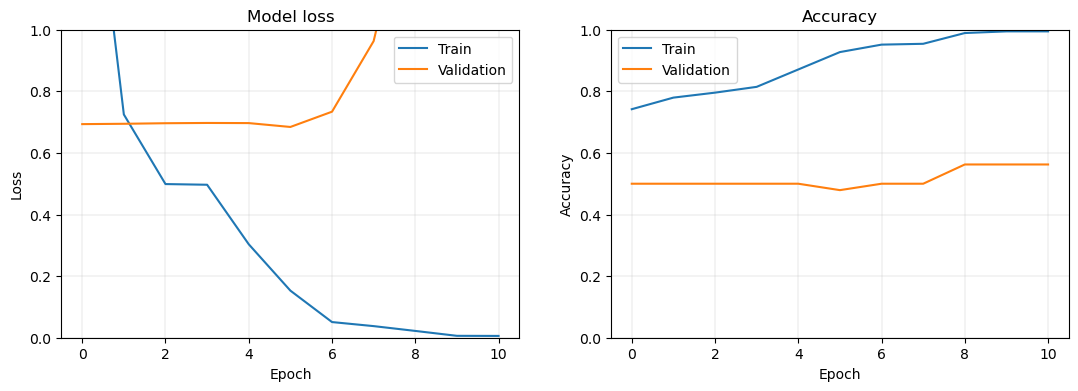

In [35]:
plot_loss(history)

In [14]:
# predictions = (sim_model.predict(X_test) > 0.5).astype("int32")
# predictions = pd.DataFrame(predictions)

# from sklearn.metrics import classification_report

# target_names = ['class 0', 'class 1', 'class 2]
# print(classification_report(y_test, predictions, target_names=target_names))

: 

: 

In [36]:
X_test.shape

(48, 190, 190, 128, 1)

In [37]:
y_test.shape

(48,)

In [38]:
X_test_small = X_test[:5,:,:,:]
y_test_small = y_test[:5]

In [17]:
predictions = sim_model.predict(X_test_small)


In [18]:
predictions.shape

(5, 1)

In [19]:
predictions

array([[1.6064037e-02],
       [2.9425246e-03],
       [6.1563319e-01],
       [4.5544009e-08],
       [3.4500004e-03]], dtype=float32)

In [21]:
y_test_small

memmap([0, 0, 0, 0, 1])

In [39]:
predictions = (sim_model.predict(X_test_small) > 0.5).astype("int32")
predictions = pd.DataFrame(predictions)

from sklearn.metrics import classification_report

target_names = ['class 0', 'class 1']
print(classification_report(y_test_small, predictions, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.80      1.00      0.89         4
     class 1       0.00      0.00      0.00         1

    accuracy                           0.80         5
   macro avg       0.40      0.50      0.44         5
weighted avg       0.64      0.80      0.71         5



/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

In [43]:
split_start = 0
split_size = 5
split_end = split_start + split_size
predictions_raw = []
predictins_filtered = []

target_names = ['class 0', 'class 1']
PREDICTION_THRESHOLD = 0.5
for _ in range(0, X_test.shape[0], split_size):

    X_test_split = X_test[split_start:split_end,:,:,:]
    y_test_split = y_test[split_start:split_end]
    predictions_raw.extend(sim_model.predict(X_test_split).flatten().tolist())
    predictions = (sim_model.predict(X_test_split) > PREDICTION_THRESHOLD).astype("int32")
    predictins_filtered.extend(predictions.flatten().tolist())
    predictions = pd.DataFrame(predictions)
    
    split_start+=5
    split_end+=5
    
    try:
        print(classification_report(y_test_split, predictions, target_names=target_names))
    except:
        pass

/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

              precision    recall  f1-score   support

     class 0       0.80      1.00      0.89         4
     class 1       0.00      0.00      0.00         1

    accuracy                           0.80         5
   macro avg       0.40      0.50      0.44         5
weighted avg       0.64      0.80      0.71         5



/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

              precision    recall  f1-score   support

     class 0       0.40      1.00      0.57         2
     class 1       0.00      0.00      0.00         3

    accuracy                           0.40         5
   macro avg       0.20      0.50      0.29         5
weighted avg       0.16      0.40      0.23         5



/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

              precision    recall  f1-score   support

     class 0       0.40      1.00      0.57         2
     class 1       0.00      0.00      0.00         3

    accuracy                           0.40         5
   macro avg       0.20      0.50      0.29         5
weighted avg       0.16      0.40      0.23         5



/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

              precision    recall  f1-score   support

     class 0       0.60      1.00      0.75         3
     class 1       0.00      0.00      0.00         2

    accuracy                           0.60         5
   macro avg       0.30      0.50      0.37         5
weighted avg       0.36      0.60      0.45         5



/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

              precision    recall  f1-score   support

     class 0       0.20      1.00      0.33         1
     class 1       0.00      0.00      0.00         4

    accuracy                           0.20         5
   macro avg       0.10      0.50      0.17         5
weighted avg       0.04      0.20      0.07         5



/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(a

              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00       0.0
     class 1       0.00      0.00      0.00       5.0

    accuracy                           0.00       5.0
   macro avg       0.00      0.00      0.00       5.0
weighted avg       0.00      0.00      0.00       5.0

              precision    recall  f1-score   support

     class 0       0.50      0.67      0.57         3
     class 1       0.00      0.00      0.00         2

    accuracy                           0.40         5
   macro avg       0.25      0.33      0.29         5
weighted avg       0.30      0.40      0.34         5



/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

              precision    recall  f1-score   support

     class 0       0.40      1.00      0.57         2
     class 1       0.00      0.00      0.00         3

    accuracy                           0.40         5
   macro avg       0.20      0.50      0.29         5
weighted avg       0.16      0.40      0.23         5



/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/svetlana.s.averina/miniconda3/envs/gpu-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

              precision    recall  f1-score   support

     class 0       0.80      1.00      0.89         4
     class 1       0.00      0.00      0.00         1

    accuracy                           0.80         5
   macro avg       0.40      0.50      0.44         5
weighted avg       0.64      0.80      0.71         5



In [45]:
results_pred = pd.DataFrame(
    {'predictions': predictins_filtered,
     'true_data': y_test #.flatten().tolist()
    })

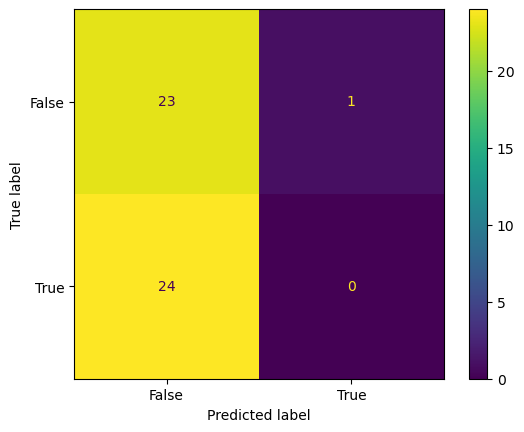

In [46]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(results_pred['true_data'], results_pred['predictions'])

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()